# Understand-Clean-Visualize-Transform-Wine Dataset

**Introduction & Goal:**

This project aims to build a *rating predictor* for our big online wine seller client. Provided dataset is a sample of whole inventory of the client (possibly [winemag](https://www.winemag.com/)) and aims to show good prediction is possible using wine predictor.

Wine predictor is going to use the sample dataset to grasp relationships between independent variables and the dependent variable, making this problem as a ***supervised machine learning*** problem. 

Dependent variable is "points", and will be referred to as ***target*** in the document. Potential independent variables are all the available columns except points, and will be referred to as ***features***. 

Our target variable consists of continuous integers ranging from 80 to 100, making this problem ***regression*** problem for us.

Our wine predictor is a machine learning model and it will generate predictions by mapping patterns, if available, of the features to the target. 

As part of this project a complete machine learning pipeline will be built with the followin steps:

1. Understand & Clean & Format Data
2. Exploratory Data Analysis
3. Feature Engineering & Pre-processing
4. Set Evaluation Metric & Establish Baseline
5. Model Selection & Tune Hyperparameters of the Model
6. Train Model
7. Evaluate Model on Test Data
8. Interpret Model Predictions
9. Conclusions

In this notebook, first we are going to explore the dataset, its features and values. Then,  we are going to try to catch some of the patterns between the target and features with the visualization tools. Finally we are going to extract and transform features to build a robust machine learning model.

In the second notebook, we are going to decide on our evaluation metric and establish a baseline. We are going select the suitable model for our wine rating predictor using the decided metric and evaluation baseline. We are going to do it by ***training*** several models using train dataset where the patterns between the features and target are mapped. After training models, we are going to search for further improvements in the best two models by tuning its hyperparamaters. Eventually, we will decide on the final model to be used in the final notebook.

In the last notebook, we are going to build the selected model with the optimal parameters and have a detailed look at how our model generates predictions. Finally, we are going to evaluate our model on the test data, where we see the results of our wine predictor. As a last step, we are going to interpret predictions and our model and summarize our conclusions.

The pipeline above will be automated for the steps:
* 1 (Clean Data)
* 3 (Extract Features, Transform Data, Impute Data)
* 6 (Train Model) 
* 7 (Evaluate Model) 

using Luigi tasks. The Luigi task flow will be as follows:

![title](LuigiTaskFlow.png)


**Remarks:**
* The dataset is a sample dataset, meaning test dataset may have first-time-seen values.
* Test dataset is expected to have 100k rows, brings attention to the performance when selecting model.

**Imports**

In [1]:
# data manipulation libraries
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 60)

# data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.pylabtools import figsize

%matplotlib inline
# to display visuals in the notebook

%config InlineBackend.figure_format='retina'
#to enable high resolution plots

# feature extraction and preprocessing
import re
import datetime

# feature transformation and preprocessing
from category_encoders.ordinal import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# to bypass warnings in section 2.5.
import warnings
warnings.filterwarnings('ignore')

**Functions to use in Parts 1 & 2**

In [2]:
# Section 1 Understand & Format & Clean Data functions
def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent],
                              axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
        columns={0: 'Missing Values', 1: '% of Total Values'})

    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = (mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1))

    # Print some summary information
    print("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
          "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns

# Section 2 Exploratory Data Analysis Functions


def plot_histogram(df, column, b=None):
    # funtion to print histogram
    # with mean and median
    # using distplot

    # set the histogram, mean and median
    g = sns.distplot(df[column],
                     kde=False,
                     bins=b)
    plt.axvline(x=df[column].mean(),
                linewidth=3,
                color='g',
                label="mean",
                alpha=0.5)
    plt.axvline(x=df[column].median(),
                linewidth=3,
                color='y',
                label="median",
                alpha=0.5)

    # set title, legends and labels
    plt.xlabel("{}".format(column),
               size=14)
    plt.ylabel("Count",
               size=14)
    plt.title("Distribution of {}".format(column),
              size=16)
    plt.legend(["mean", "median"])

    return g


def plot_distribution(df, target, column_values, column_name):
    # funtion to print distribution of a continuous variable
    # for categorical data

    for value in column_values:
        subset = df[
            df[column_name] == value]
        g = sns.kdeplot(subset[target],
                        label=value,
                        linewidth=3)

    # set title, legends and labels
    plt.ylabel("Density",
               size=14)
    plt.xlabel("{}".format(target),
               size=14)
    plt.title("Distribution of {} per {}"
              .format(target, column_name),
              size=16)

    return g


def create_province_list(df, country_name):
    # funtion to create list of provinces
    # for a given country name
    indexed_train = df.set_index("country")
    province_list = list(
        indexed_train
        .loc[country_name]["province"]
        .unique())
    return province_list

## Understand, Clean and Format Data

In [3]:
train = pd.read_csv("../data_root/interim/train.csv")
test = pd.read_csv("../data_root/interim/test.csv")

In [4]:
print("There are {} rows and {} columns in the train dataset."
      .format(train.shape[0], train.shape[1]))

There are 9000 rows and 13 columns in the train dataset.


In [5]:
print("There are {} rows and {} columns in the test dataset."
      .format(test.shape[0], test.shape[1]))

There are 1000 rows and 13 columns in the test dataset.


Train dataset is the dataset that we are going to build our model on, test dataset will be used for evaluation.

### Descriptive statistics & information about datasets 

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   country                8994 non-null   object 
 1   description            9000 non-null   object 
 2   designation            6455 non-null   object 
 3   points                 9000 non-null   int64  
 4   price                  8403 non-null   float64
 5   province               8994 non-null   object 
 6   region_1               7505 non-null   object 
 7   region_2               3469 non-null   object 
 8   taster_name            7223 non-null   object 
 9   taster_twitter_handle  6888 non-null   object 
 10  title                  9000 non-null   object 
 11  variety                9000 non-null   object 
 12  winery                 9000 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 914.2+ KB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   country                1000 non-null   object 
 1   description            1000 non-null   object 
 2   designation            716 non-null    object 
 3   points                 1000 non-null   int64  
 4   price                  920 non-null    float64
 5   province               1000 non-null   object 
 6   region_1               831 non-null    object 
 7   region_2               384 non-null    object 
 8   taster_name            792 non-null    object 
 9   taster_twitter_handle  756 non-null    object 
 10  title                  1000 non-null   object 
 11  variety                1000 non-null   object 
 12  winery                 1000 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 101.7+ KB


In [8]:
train.describe()

points        price
count  9000.000000  8403.000000
mean     88.455222    35.532191
std       3.025945    40.750683
min      80.000000     5.000000
25%      86.000000    17.000000
50%      88.000000    25.000000
75%      91.000000    42.000000
max     100.000000  1300.000000

Majority of the features are categorical and we have some missing data in the both datasets. Machine learning models can only work with numerical and non-empty values. Thus we are going to develop strategies in *Feature Engineering* to impute the missing data and transform categorical values into the numeric values.

### Description of features and target

In [9]:
train.head()

country                                        description  \
0            US  Expressive aromas of smoke, embers and blue fr...   
1  South Africa  Soft mint, spice, cocoa and smoke on the nose ...   
2      Portugal  An elegant, finely rounded wine, with firm tan...   
3  South Africa  Winemaker: Louis Nel. This Cab-Shiraz blend is...   
4      Portugal  Lightly wood aged and spicy, this is a fine re...   

                         designation  points  price      province  \
0                                NaN      88   35.0    Washington   
1                            Redhill      89   30.0  Stellenbosch   
2                                NaN      90    NaN         Douro   
3  Cape Winemakers Guild Rapscallion      91    NaN  Stellenbosch   
4        Casa Américo Branco Reserva      90    NaN           Dão   

               region_1         region_2       taster_name  \
0  Columbia Valley (WA)  Columbia Valley  Sean P. Sullivan   
1                   NaN              NaN   Susan Kostrzewa   
2                   NaN              NaN        Roger Voss   
3                   NaN              NaN     Lauren Buzzeo   
4                   NaN              NaN        Roger Voss   

  taster_twitter_handle                                              title  \
0         @wawinereport           Damsel 2013 Syrah (Columbia Valley (WA))   
1         @suskostrzewa      Simonsig 2005 Redhill Pinotage (Stellenbosch)   
2            @vossroger                 Quinta de la Rosa 2008 Red (Douro)   
3             @laurbuzz  Louis Nel 2015 Cape Winemakers Guild Rapscalli...   
4            @vossroger  Seacampo 2014 Casa Américo Branco Reserva Encr...   

                     variety             winery  
0                      Syrah             Damsel  
1                   Pinotage           Simonsig  
2             Portuguese Red  Quinta de la Rosa  
3  Cabernet Sauvignon-Shiraz          Louis Nel  
4                  Encruzado           Seacampo

In [10]:
train.sample(5)

country                                        description  \
561       US  There is no lack of dark, smoky flavors in thi...   
2488      US  These old vines are from the original 1971 est...   
7586      US  The nose on this bottling is very smoky and fl...   
6907   Italy  Aromas of exotic spice, iris, leather, forest ...   
7675      US  This is Barlow's Bordeaux blend. Based on Cabe...   

                 designation  points  price    province              region_1  \
561                      NaN      88   26.0      Oregon          Rogue Valley   
2488                     NaN      88   28.0      Oregon           McMinnville   
7586                 Lot 526      87   14.0  California  Santa Barbara County   
6907  Rocche dell'Annunziata      92   69.0    Piedmont                Barolo   
7675                Barrouge      90   40.0  California           Napa Valley   

               region_2    taster_name taster_twitter_handle  \
561     Southern Oregon   Paul Gregutt           @paulgwine    
2488  Willamette Valley   Paul Gregutt           @paulgwine    
7586      Central Coast  Matt Kettmann         @mattkettmann   
6907                NaN  Kerin O’Keefe          @kerinokeefe   
7675               Napa            NaN                   NaN   

                                                  title  \
561        Silvan Ridge 2013 Tempranillo (Rogue Valley)   
2488           Hyland 2013 Gewurztraminer (McMinnville)   
7586  Cameron Hughes 2014 Lot 526 Chardonnay (Santa ...   
6907  Mauro Veglio 2012 Rocche dell'Annunziata  (Bar...   
7675             Barlow 2005 Barrouge Red (Napa Valley)   

                       variety          winery  
561                Tempranillo    Silvan Ridge  
2488            Gewürztraminer          Hyland  
7586                Chardonnay  Cameron Hughes  
6907                  Nebbiolo    Mauro Veglio  
7675  Bordeaux-style Red Blend          Barlow

With some intuition, expert knowledge and help of Google here are the explanation of features and target:

* **country:** Origin of the wine producer
* **description:** Presentment of the taster to describe the wine 
* **designation:** Name of the wine given to the wine by the producer, sometimes used interchangeably with vineyard. Usually available in the title.
* **points:** Our target value, representing score of a particular wine received from a taster. An important remark is, a wine may receive different points from the same taster. 
* **price:** Price of the wine
* **region_1:** Official definition of the place where the grapes for a wine are grown
* **region_2:** Official definition of the place where the grapes for a wine are grown
* **taster_name:** The taster, as obvious assigns points to the wine
* **title:** Name of the wine, as available on the label
* **variety:** Grape variety of the wine
* **winery:** name of the wine producer

### Missing values of the datasets

In [11]:
missing_values_table(train)

Your selected dataframe has 13 columns.
There are 8 columns that have missing values.


Missing Values  % of Total Values
region_2                         5531               61.5
designation                      2545               28.3
taster_twitter_handle            2112               23.5
taster_name                      1777               19.7
region_1                         1495               16.6
price                             597                6.6
country                             6                0.1
province                            6                0.1

In [12]:
missing_values_table(test)

Your selected dataframe has 13 columns.
There are 6 columns that have missing values.


Missing Values  % of Total Values
region_2                          616               61.6
designation                       284               28.4
taster_twitter_handle             244               24.4
taster_name                       208               20.8
region_1                          169               16.9
price                              80                8.0

Features that have missing values more than 50% will be dropped since they aren't likely to provide significant information to the machine learning model. 

In this sample dataset, target value has no missing values, if we had some, we would drop all the missing values of the target to not to leak any data or distort the existing distribution of the target.

Considering above comments and looking at the missing values, region_2 will be dropped.

### Cardinality of non-numeric features

In [13]:
object_columns = (train
                  .select_dtypes(include="object")
                  .columns)

for column in object_columns:
    print("{} has {} unique values."
          .format(column, 
                  train[column]
                  .nunique()))

country has 37 unique values.
description has 8948 unique values.
designation has 4913 unique values.
province has 236 unique values.
region_1 has 699 unique values.
region_2 has 17 unique values.
taster_name has 18 unique values.
taster_twitter_handle has 14 unique values.
title has 8937 unique values.
variety has 325 unique values.
winery has 5097 unique values.


***Cardinality*** is the number of unique values that a feature has.

**We have some high-cardinality features:**
* description
* designation
* title
* winery

**We have some moderate-cardinality features:**
* province
* region_1
* variety

**We have some low-cardinality features:**
* country
* taster_name
* taster_twitter_handle

Description contains information about wine's color, taste and notes (like citrus, tannins). Title feature contains year of the wine produced. Variety has the information about if different type of grapes are blended or not. They can be used to extract more features.

High cardinality features will be dropped from the dataset, if not used for feature extraction.

Most frequent values of moderate  and low cardinality features will be explored in the *Exploratory Data Analysis*.

### Unique values of taster_name and taster_twitter_handle

In [14]:
taster_names = train["taster_name"].unique()

for value in taster_names:
    print(value)

Sean P. Sullivan
Susan Kostrzewa
Roger Voss
Lauren Buzzeo
Joe Czerwinski
Michael Schachner
Jim Gordon
Kerin O’Keefe
Matt Kettmann
nan
Paul Gregutt
Virginie Boone
Anna Lee C. Iijima
Jeff Jenssen
Mike DeSimone
Anne Krebiehl MW
Alexander Peartree
Fiona Adams
Carrie Dykes


In [15]:
taster_twitter_handles = (train["taster_twitter_handle"]
                          .unique())

for value in taster_twitter_handles:
    print(value)

@wawinereport
@suskostrzewa
@vossroger
@laurbuzz
@JoeCz
@wineschach
@gordone_cellars
@kerinokeefe
@mattkettmann
nan
@paulgwine 
@vboone
@worldwineguys
@AnneInVino
@bkfiona


The objective is to show good prediction is possible using wine predictor, which is a machine learning model itself. A "good prediction" is possible with features of independent variables that are predictive of the points. 

So we do not want to use dependent features (like taster_twitter_handle and the taster_name) when building our model, because they are providing the same information to the model and possibly making it unnecessarily complicated. 

After some online research and making sure that each unique value of taster_twitter_handle is available in the taster_name feature, we can remove taster_twitter_handle to build a good predictor.

###  Clean data

Our dataset contains duplicate rows, which I realized by following the clue of some of the rows having same descriptions.

* high-cardinality features not used in feature extraction: designation, winery
* high-percentage missing value features: region_2
* dependent features: taster_twitter_handle
* duplicate rows
* rows that have missing values in the points

Both datasets will be cleaned by dropping them.

In [16]:
def CleanData(df):
    # this function drops not used features
    # and duplicate rows
    # and empty rows of target(poinst)
    # returns cleaned df

    drop_columns = ["designation",
                    "winery",
                    "region_2",
                    "taster_twitter_handle"]
    interim_df = df.drop(columns=drop_columns)

    interim_df_2 = (interim_df
                    .drop_duplicates(ignore_index=True))
    
    cleaned_df = (interim_df_2
                  .dropna(subset=["points"], 
                          how="any")
                  .reset_index(drop=True))
    
    return cleaned_df

In [17]:
train_cleaned = CleanData(train)
test_cleaned = CleanData(test)

### Findings from Understand & Clean & Format Data

In [18]:
print(
    "After the Understand & Clean & Format Data part {} rows and {} columns left in the train dataset."
    .format(train_cleaned.shape[0], 
            train_cleaned.shape[1]))
print(
    "After the Understand & Clean & Format Data part {} rows and {} columns left in the test dataset."
    .format(test_cleaned.shape[0], 
            test_cleaned.shape[1]))

After the Understand & Clean & Format Data part 8948 rows and 9 columns left in the train dataset.
After the Understand & Clean & Format Data part 1000 rows and 9 columns left in the test dataset.


* Non-numeric features are grouped as high, moderate and low cardinality features. Moderate and low cardinality features will be explored in the *Exploratory Data Analysis* part.
* Features to be used for feature extraction (description, title and variety) in *Feature Engineering* part is pre-determined.
* Duplicate rows, not-used features and dependent features are dropped. As a result we are left with 8 features in total. 8948 are left in the train dataset, test dataset row count did not change.

## Exploratory Data Analysis

### Distribution of points

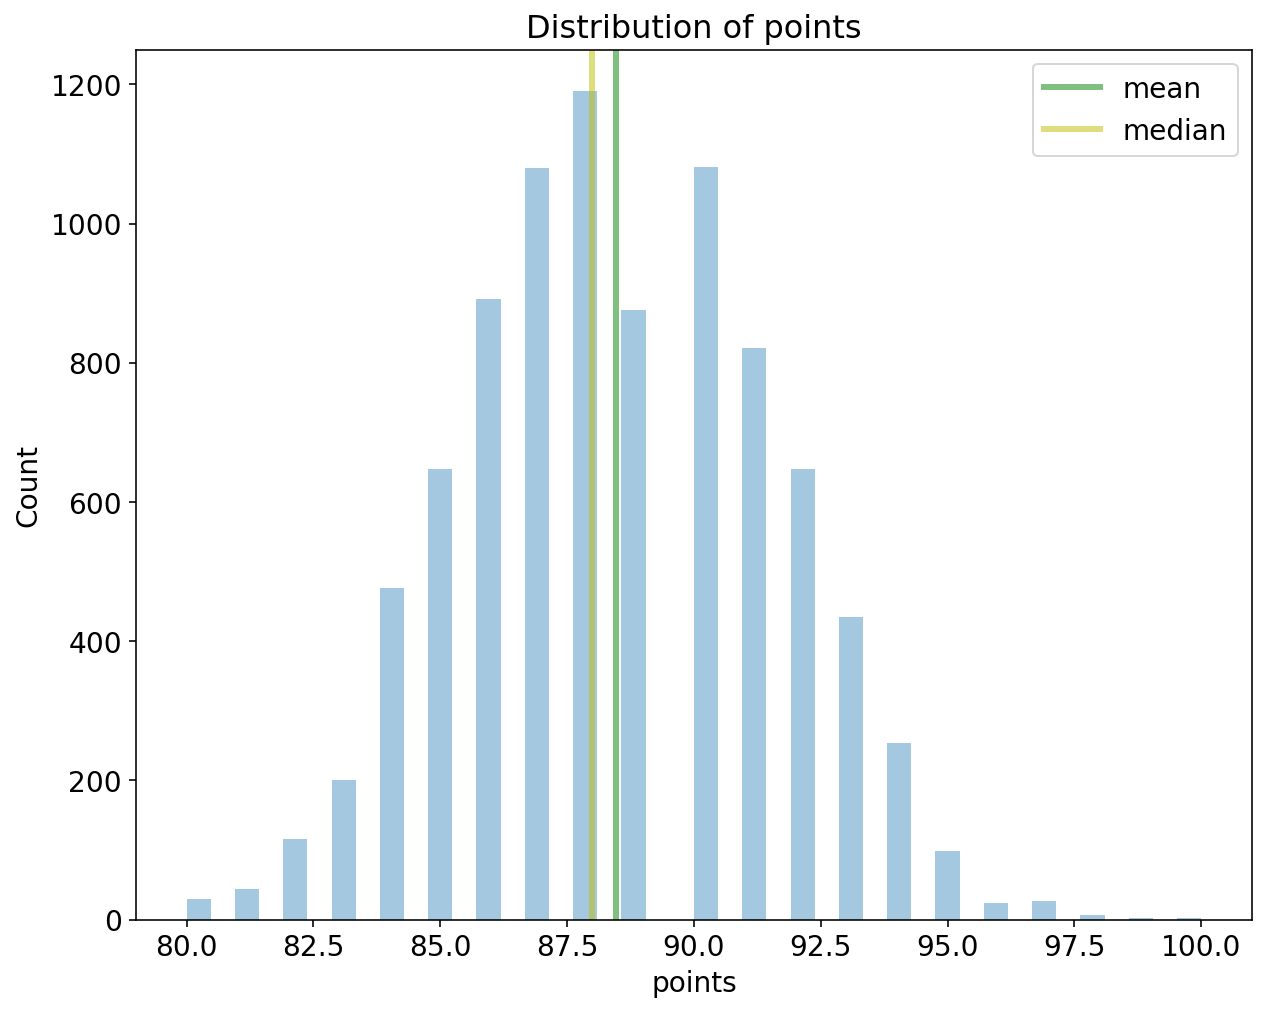

In [19]:
figsize(10, 8)
plt.rcParams['font.size'] = 14
plot_histogram(train_cleaned, "points")

***Distribution*** is a description of a variable's range and how data is spread in that range.

Points show a normal distribution (a bell shaped curve obvious) as expected from a random variable. Range of wine points are distributed between 80 and 100 with the average (mean) of 88.45 and median (the middle value) of 88. Moreover, standard deviation, a measure of spread of a data range, is 3.03. Based on this statistics, we can confidently say that:

* 68% of the points lie in the 85.5 - 91.5 range
* 95% of the points lie in the 82.5 - 94.5 range
* 99% of the points lie in the 79.5 - 97.5 range

Alternatively, we can see the points as a classification of wines and interpret points as different classes according to [wine searcher](https://www.wine-searcher.com/critics-17-wine+enthusiast):

* 98–100: Classic
* 94–97: Superb
* 90–93: Excellent
* 87–89: Very good
* 83–86: Good
* 80–82: Acceptable

However, this would be different wine predictor, which we will not touch is scope of this project.

### Distribution of price

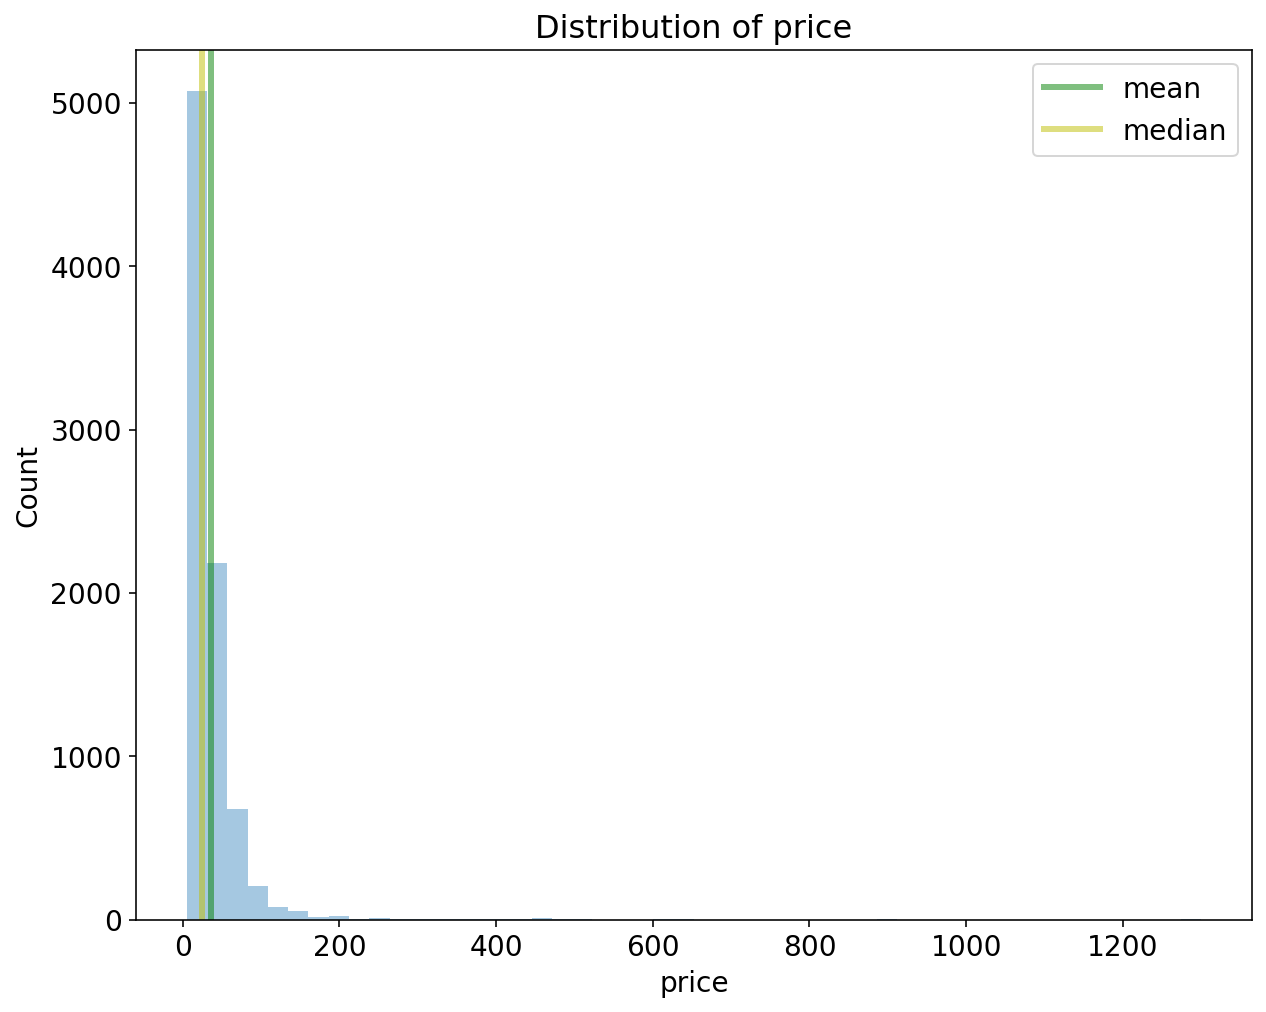

In [20]:
figsize(10, 8)
plt.rcParams['font.size'] = 14
plot_histogram(train_cleaned, "price")

Price is concentrated between the range 0-200, which is defined as ***right-skewed*** distribution. 

This can be interpreted as majority of the wine prices are lower than 200 and most of them are cheaper wine, explaining the spike near 0.

This is also an indicator of we have a few very expensive wines, extending price to 1200.

**Distribution of Price in the range 0-200**

(0, 200)

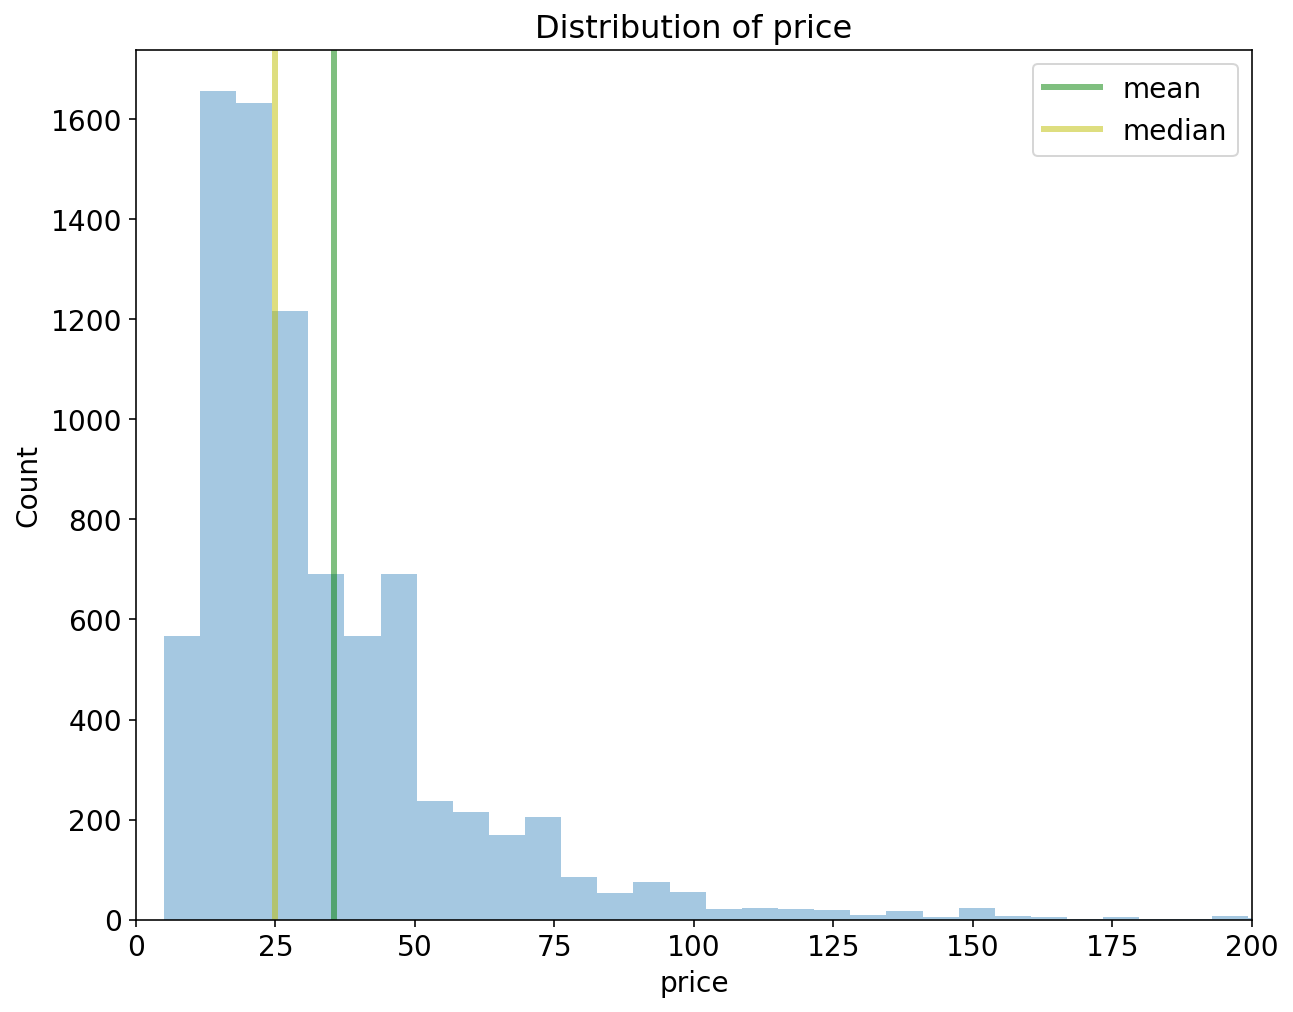

In [21]:
figsize(10, 8)
plt.rcParams['font.size'] = 14
plot_histogram(train_cleaned, "price", 200)
plt.xlim(0,200)
# plt.savefig("PriceDistribution.png")

This gives us a better picture of price distribution. It is still a right-skewed distribution but we can more clearly see that most the wine price's are less than 50. Median of the price is 25 and the average price is 35.5.

In order to use price as a predictor, we need to assume a points received of a wine does not cause any price change. Otherwise, price feature would cause data leakage which would spoil our future predictions of points. 

Nonetheless, price is an indicator of wine's quality and age and assuming it is not affected by the points received, it will be an important determiner for the model.

### Points VS country

In [22]:
# for understandable plots wines from 
# themost frequent countries' points
# will be visualized
countries = (train_cleaned["country"]
             .value_counts())

freq_countries = list(
    countries[
        countries.values > 300]
    .index)

freq2_countries = list(
    countries[
        (countries.values <= 300) &
        (countries.values >= 100)]
    .index)

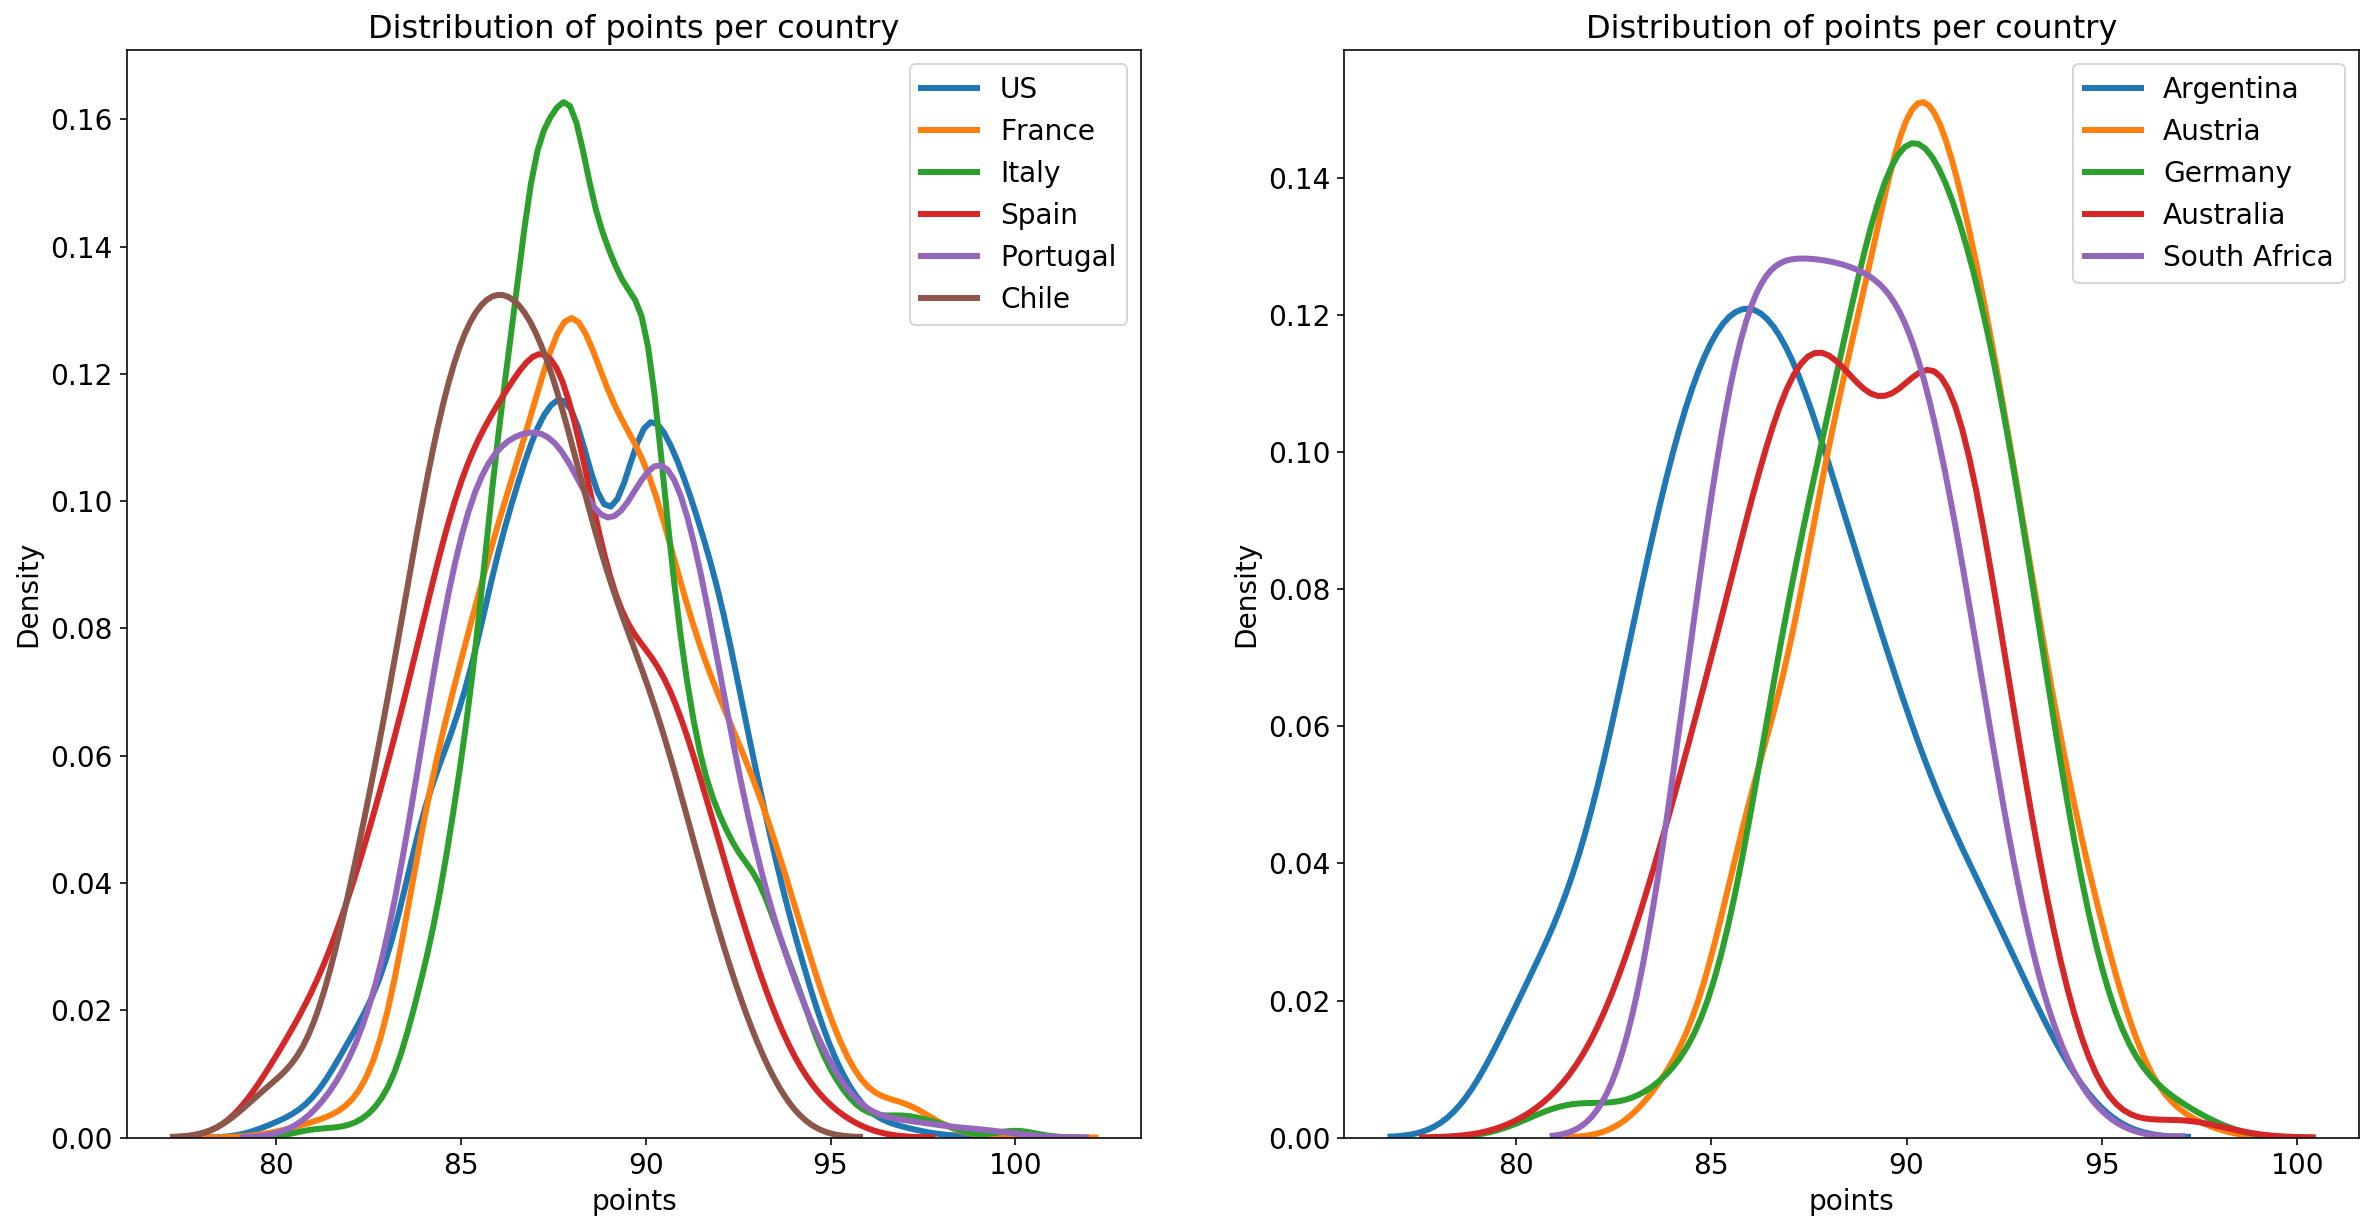

In [23]:
# distribution of the points per country
figsize(20, 10)
plt.rcParams['font.size'] = 14

# plot points distribution for most frequent countries
plt.subplot(1, 2, 1)
plot_distribution(train_cleaned, "points",
                  freq_countries, "country")

# plot points distribution for second most frequent countries
plt.subplot(1, 2, 2)
plot_distribution(train_cleaned, "points",
                  freq2_countries, "country")

Wine producing market is dominated by US, France, Italy and Spain which is easily available from the plots. In general, country is a differentiating feature to determine points of a wine. However, there are some exception country pairs that have same points distribution:

* USA - Portugal
* Austria - Germany
* Argentina - Chili

### Points VS price in most frequent countries

In [24]:
# to select most frequent countries
points_freq_countries = train_cleaned[
    train_cleaned
    .country
    .isin(freq_countries)]

(0, 200)

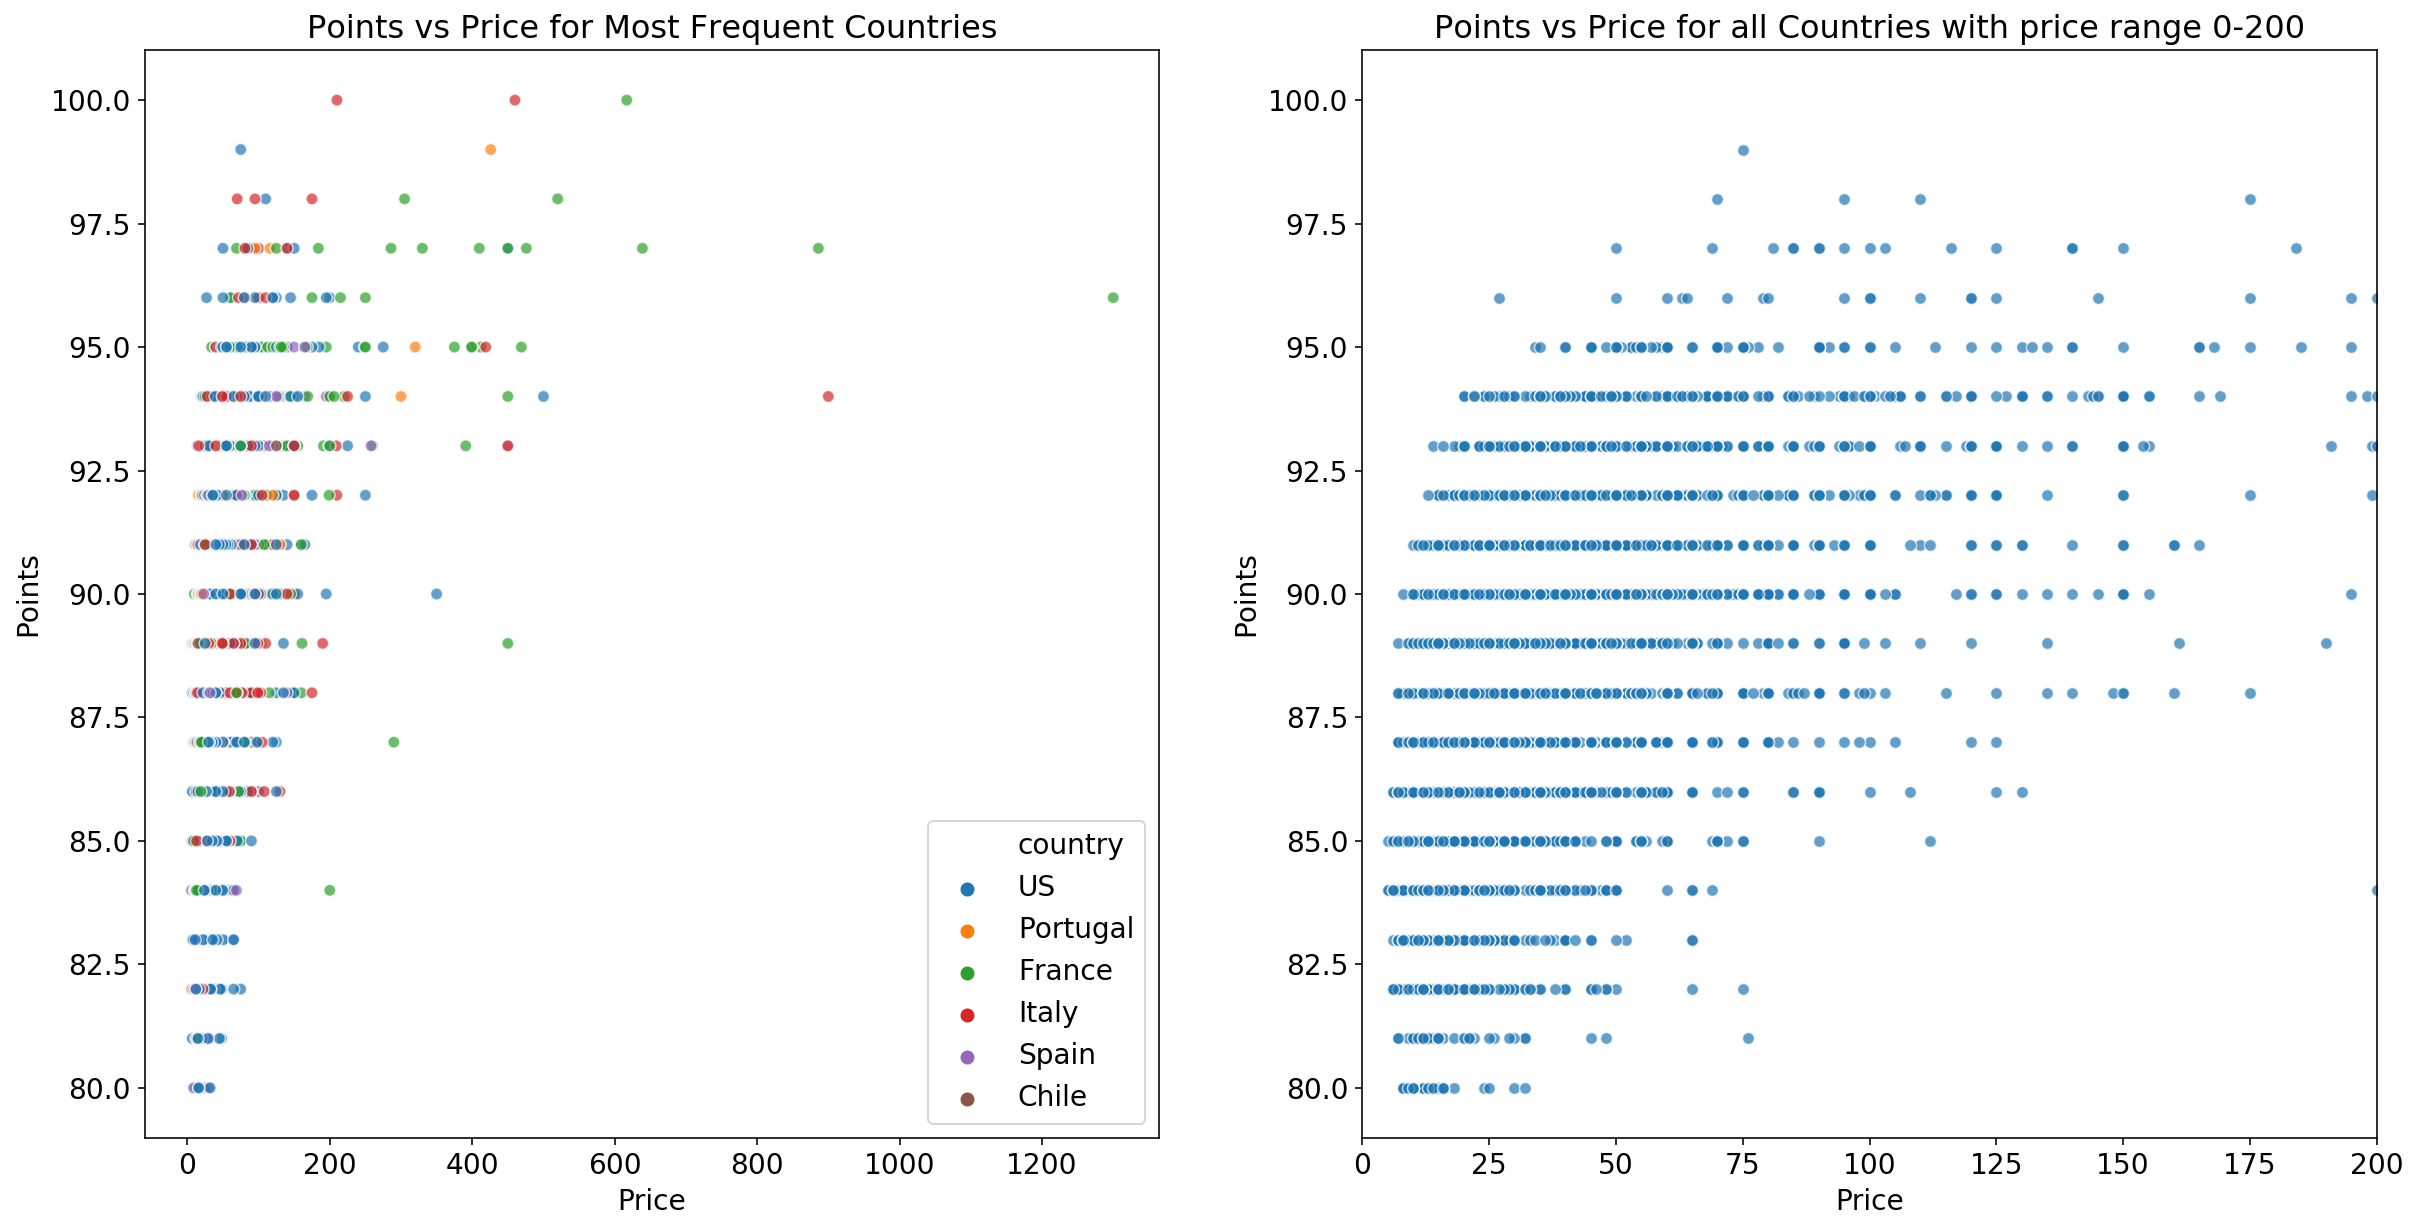

In [25]:
# set plot size and font size
figsize(20, 10)
plt.rcParams['font.size'] = 14

# plot a scatterplot of Points and Price
plt.subplot(1,2,1)
sns.scatterplot(x='price', y='points',
                hue='country', 
                data=points_freq_countries,
                alpha=0.7)

# Plot labeling
plt.xlabel("Price", size=14)
plt.ylabel("Points", size=14)
plt.title("Points vs Price for Most Frequent Countries", 
          size=16)


# plot a scatterplot of Points and Price
plt.subplot(1,2,2)
sns.scatterplot(x='price', y='points', 
                data=train_cleaned,
                alpha=0.7)

# Plot labeling
plt.xlabel("Price", size=14)
plt.ylabel("Points", size=14)
plt.title("Points vs Price for all Countries with price range 0-200", 
          size=16)
plt.xlim(0,200)

Chart on the left-hand side shows the points and price relationship for the wines produced by US, Portugal, France, Italy, Spain and Chile. Chart on the left hand side shows the points and price relationship for all countries, zoomed in 0 and 200 price range.

Both charts shows there is a positive trend between points and price, which serves as a proof that price is an important predictor.

Some other valuable insights are there are two wines from Italy and one from France that received full points from tasters, all of their prices are greater than 200.

In [26]:
# look at the top wines
train_cleaned[
    train_cleaned["points"] == 100]

country                                        description  points  \
4026  France  This new release from a great vintage for Char...     100   
6073   Italy  A perfect wine from a classic vintage, the 200...     100   
8250   Italy  Thick as molasses and dark as caramelized brow...     100   

      price   province                    region_1 taster_name  \
4026  617.0  Champagne                   Champagne  Roger Voss   
6073  460.0    Tuscany                     Toscana         NaN   
8250  210.0    Tuscany  Vin Santo di Montepulciano         NaN   

                                                  title           variety  
4026  Salon 2006 Le Mesnil Blanc de Blancs Brut Char...        Chardonnay  
6073  Tenuta dell'Ornellaia 2007 Masseto Merlot (Tos...            Merlot  
8250  Avignonesi 1995 Occhio di Pernice  (Vin Santo ...  Prugnolo Gentile

### Points VS province in most frequent countries

In [27]:
# make lists of provinces
provinces_us = create_province_list(
    train_cleaned, "US")
provinces_fr = create_province_list(
    train_cleaned, "France")
provinces_it = create_province_list(
    train_cleaned, "Italy")
provinces_es = create_province_list(
    train_cleaned, "Spain")

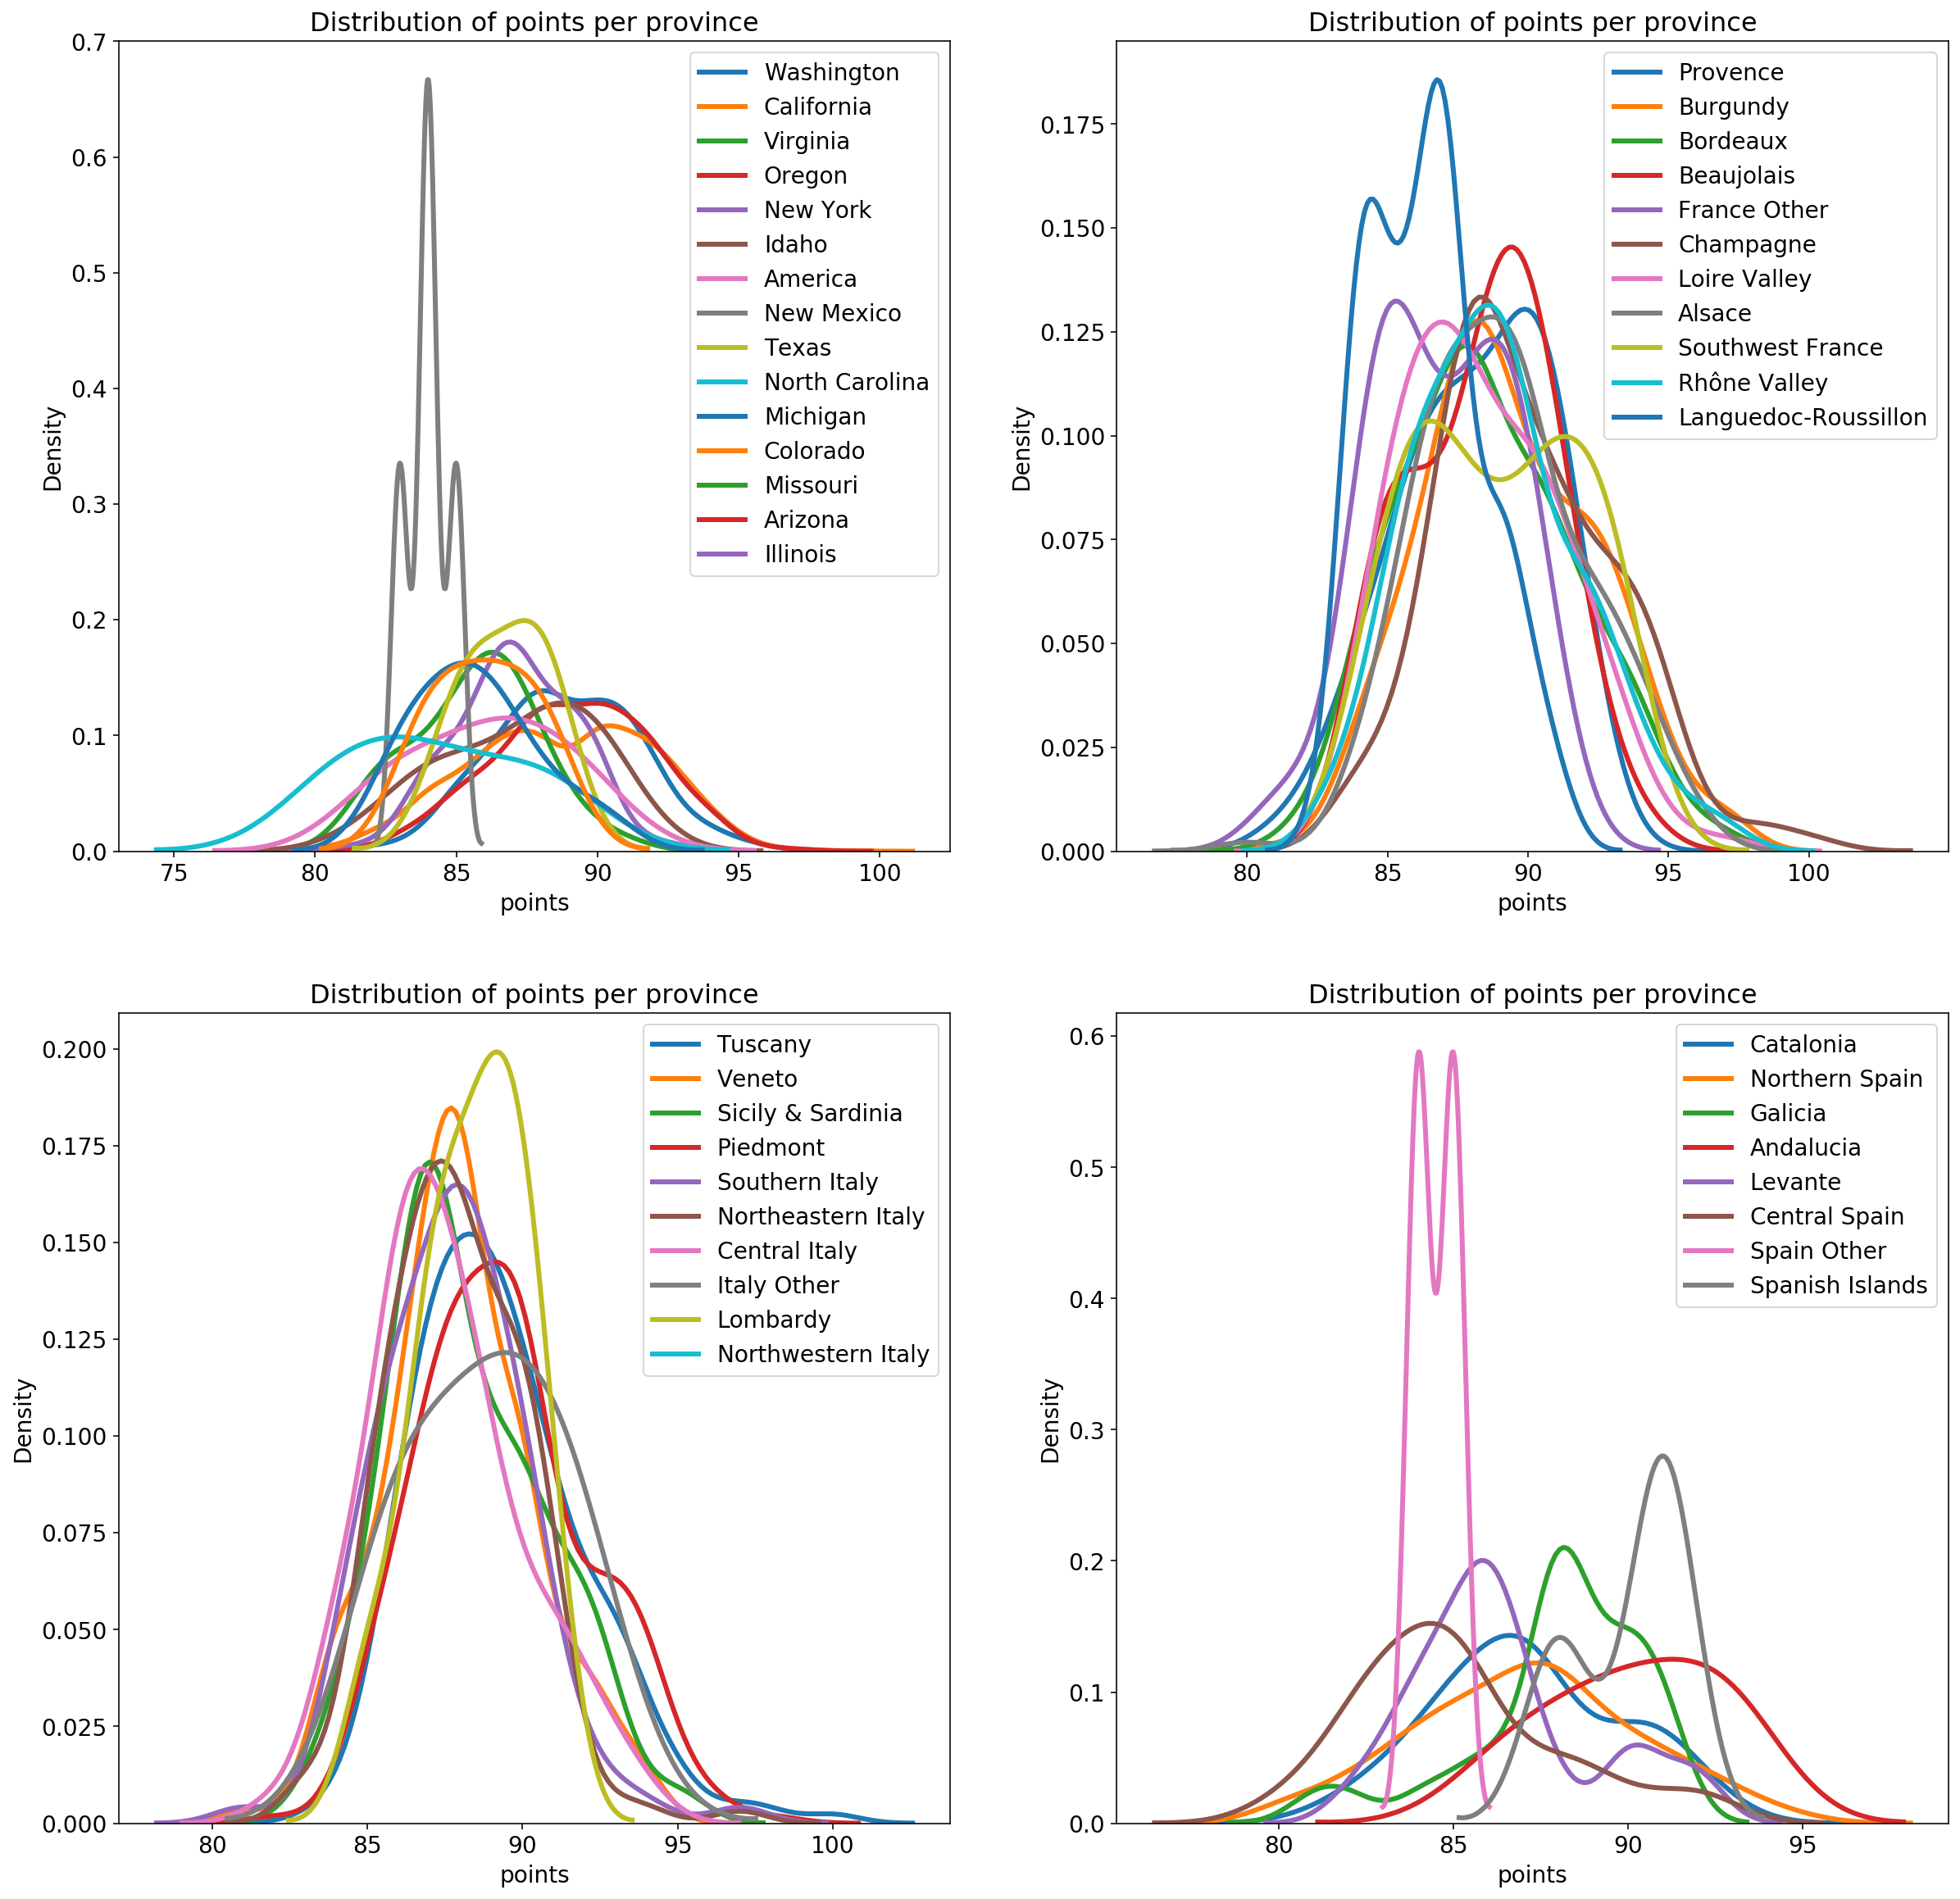

In [28]:
# distribution of provinces
figsize(20, 20)
plt.rcParams['font.size'] = 14

# plot points distribution for provinces
plt.subplot(2,2,1)
plot_distribution(train_cleaned, "points", 
                  provinces_us, "province")

# plot points distribution for provinces
plt.subplot(2,2,2)
plot_distribution(train_cleaned, "points", 
                  provinces_fr, "province")

# plot points distribution for provinces
plt.subplot(2,2,3)
plot_distribution(train_cleaned, "points", 
                  provinces_it, "province")

# plot points distribution for provinces
plt.subplot(2,2,4)
plot_distribution(train_cleaned, "points", 
                  provinces_es, "province")

Province is a differentiating factor for US and Spanish wine points. For the points of Italian wines, province is less effective in determining a point of a wine. Provence province of France stands out against all French provinces.

All in all province provides location information when it is combined with country feature, so both are going to be available in the final feature set.

### Points VS taster_name

Text(0.5, 1.0, 'Points from Different Tasters')

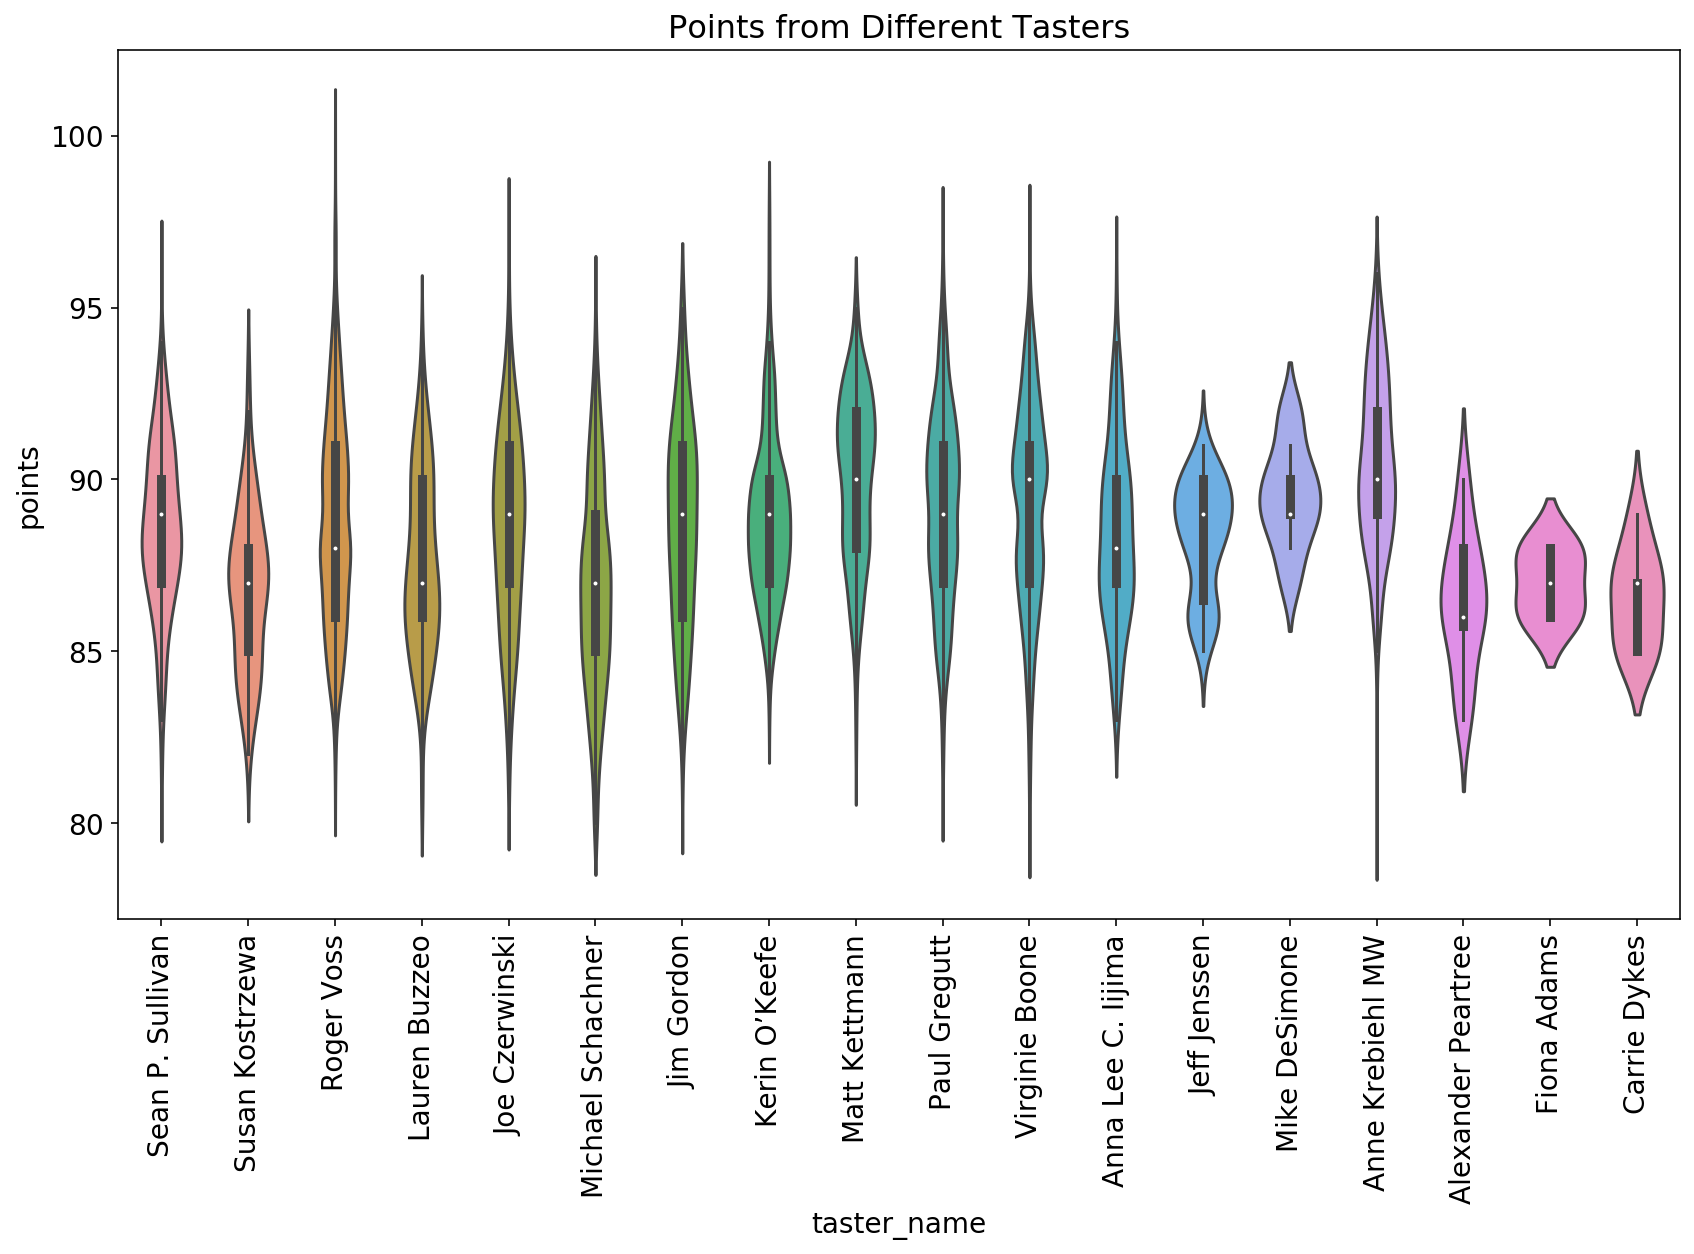

In [29]:
# set plot size and font size
figsize(14, 8)
plt.rcParams['font.size'] = 14

# violin plot to see descriptive statistics 
# and distribution
# per taster_name
f = sns.violinplot(data=train_cleaned,
                   x="taster_name",
                   y="points")

f.set_xticklabels(f.get_xticklabels(),
                  rotation=90)

plt.title("Points from Different Tasters",
          size=16)

Violins shows the distribution of the points and their descriptive statistics together per taster. It is clear that each taster's descriptive statistics and distribution of points are unique.

Looking at this picture, taster_name could be the second most important predictor of a points of a wine.

### Points VS variety

In [30]:
# make list of most-appearing varieties
varieties = (train_cleaned["variety"]
             .value_counts())

freq_varieties = list(
    varieties[
        varieties.values > 200]
    .index)

freq2_varieties = list(
    varieties[
        (varieties.values <= 200) & 
        (varieties.values >= 100)]
    .index)

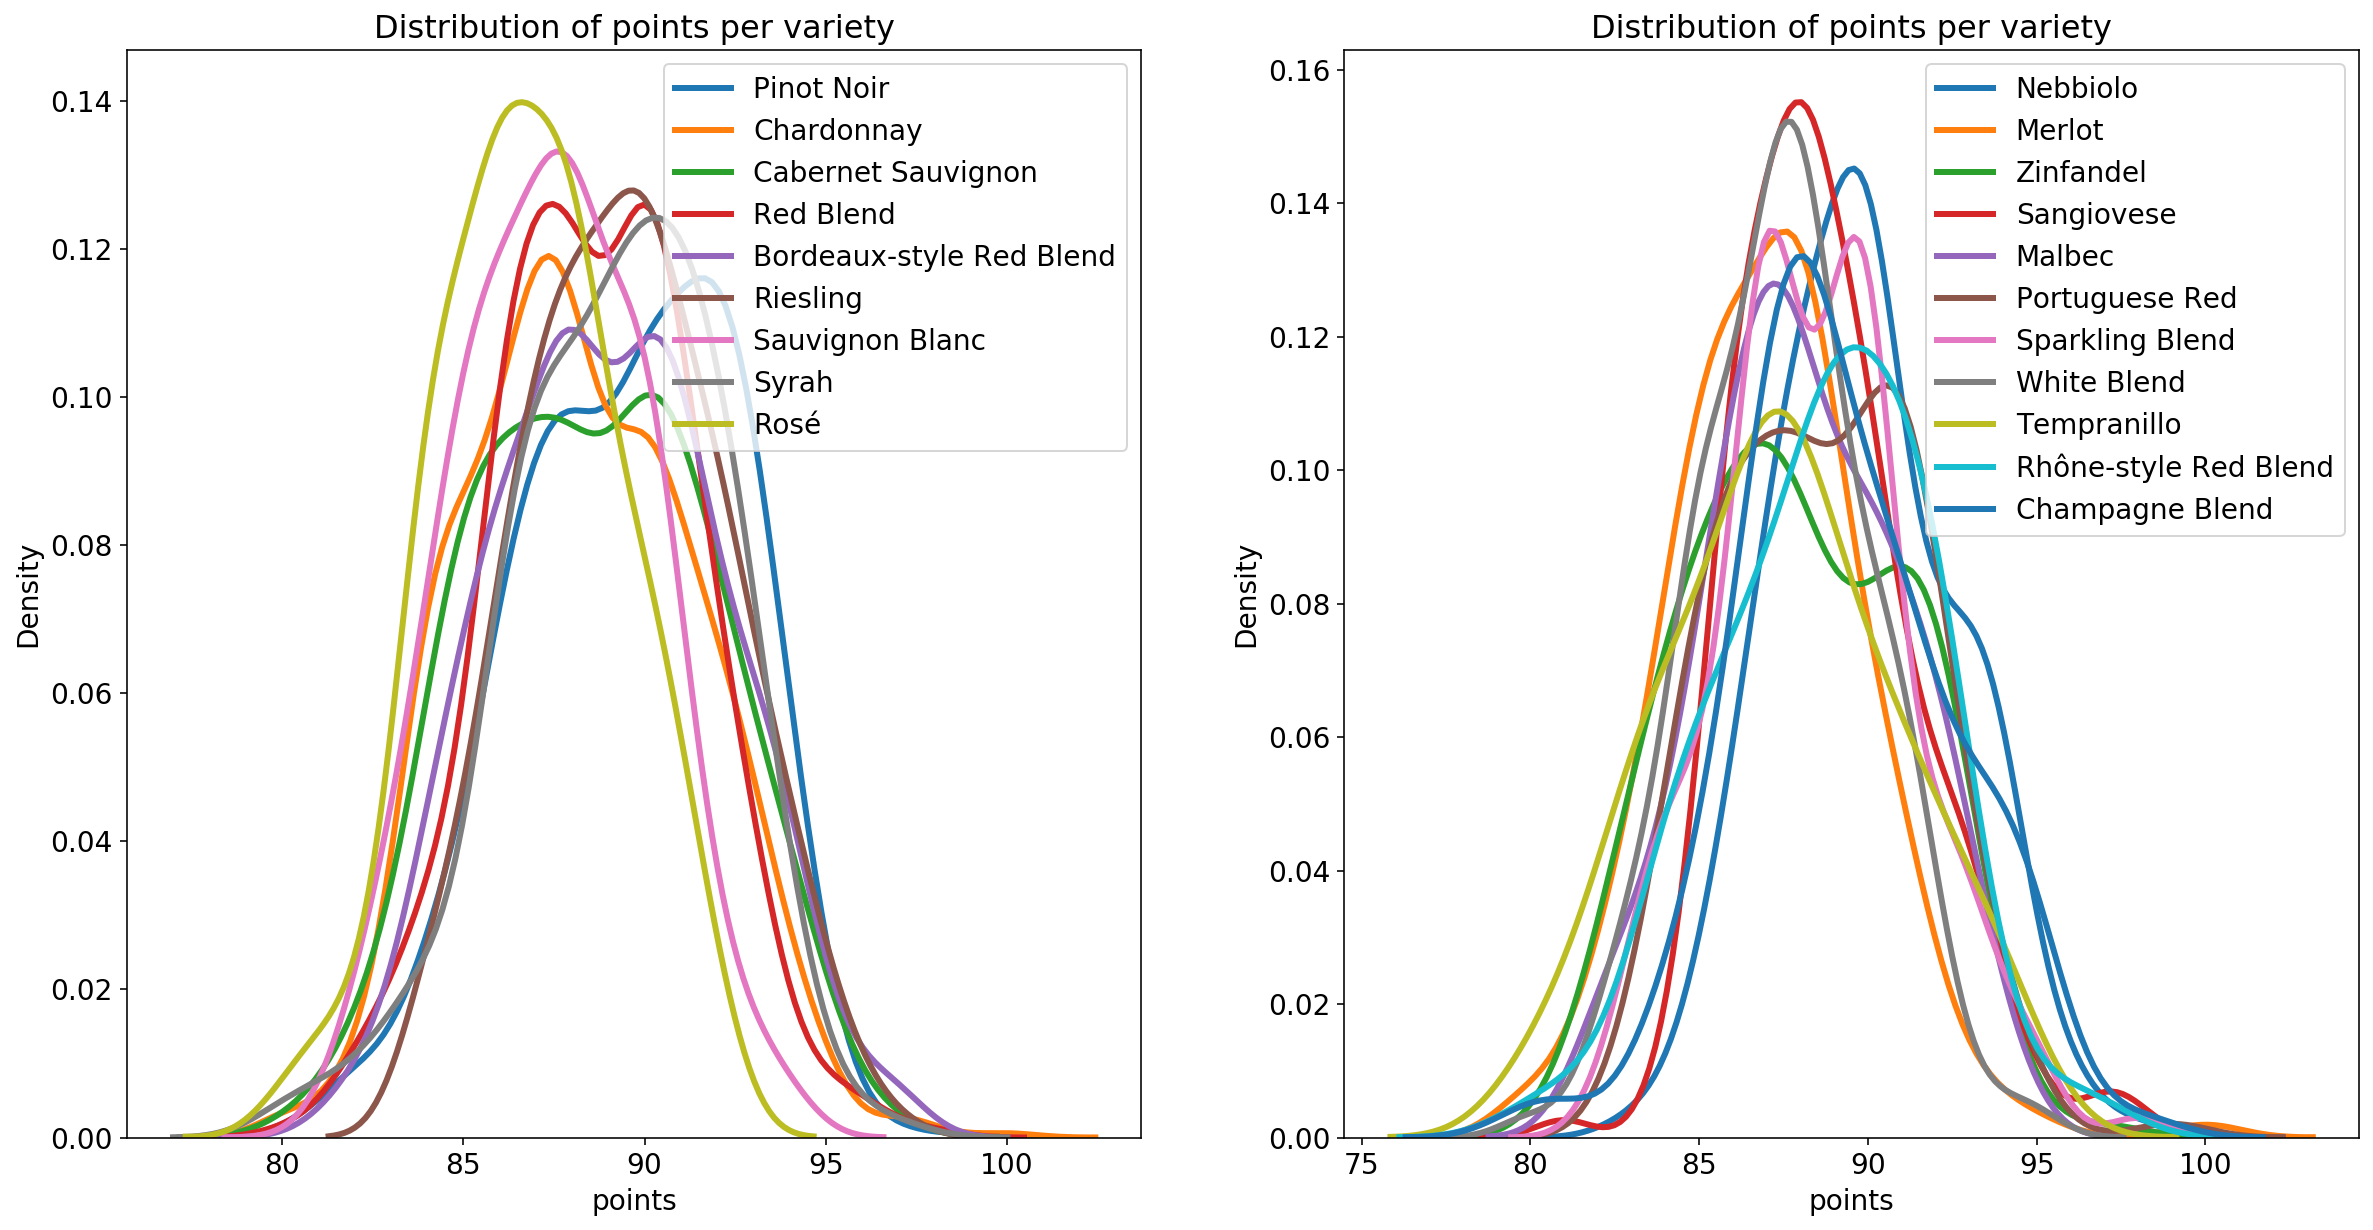

In [31]:
# distribution of the points per variety
figsize(20, 10)
plt.rcParams['font.size'] = 14

# plot points distribution for frequent varieties
plt.subplot(1,2,1)
plot_distribution(train_cleaned, "points", 
                  freq_varieties, "variety")

# plot points distribution for second most frequent varieties
plt.subplot(1,2,2)
plot_distribution(train_cleaned, "points", 
                  freq2_varieties, "variety")

There is not much information available about how variety affects points distribution, but from my own experience it is a major element in determining wine's taste, so I will use variety as a feature.

### Findings from exploratory data analysis

**Points**:
* Points are normally distributed. Range of points are between 80 and 100.
* There are 3 wines that have points of 100.
* 99% of the points are between 79.5 - 97.5 with a mean of 88.5 and median of 88.

**Price**:
* Most of the wine prices are lower than 200 with a mean of 35.5 and median of 25.
* There is a positive correlation between the points of a wine and its price, making price an important feature.

**Country**:
* Distribution of points per country is mostly different with several exception country pairs.

**Province**:
* Province has effect in points distribution in all countries, except Italy.

**Taster name:**
* Taster_name may be the second most important feature in determining points since distribution shape and descriptive statistics of a taster is unique. 

**Region_1**:
* Since it is the official definition of the place where the grapes for a wine are grown, and it may important as the variety is important it will be kept in the feature list

## Feature Engineering

***Feature engineering*** is a process of extracting, transforming and removing features.

Using findings of *Understand & Clean & Format Data* and *Exploratory Data Analysis* we are going to prepare features for our machine learning models. 

**Our feature engineering steps will be as follows:**

**1. Feature Extraction:** 
* from description: is_red, is_white, is_rose, is_dry, is_sweet and is_sparkling
* from title: year
* from variety: is_blend

**2. Categorical Feature Transformation:** 

Categorical features (country, province, region_1, taster_name and variety) will be turned into numerical data, by using process of ordinal encoding. ***Ordinal encoding*** is the process of assigning positive integers consecutively to each unique value of a particular feature. Ordinal encoding approach is selected because of the possibility of having an unseen feature value in the test dataset.

**3. Missing Value Imputation:** 
* taster_name: will be filled with constant value as 0, as stands for "Unknown"
* price and year: will be filled with median since median value is robust to outliers
* country, province, region_1 and variety: will be filled with most_frequent value, since the most_frequent value values of each feature aligns. They are: US, California, Napa Valley and Pinot Noir respectively.

**4. Training and Validation Split:**

Training dataset will be used for training the machine learning model. ***Training a machine learning model*** is the process of the model's grasping the patterns between the features and the target, and using them for further predictions. This process should be done by holding out a slice from the training set before inputting into the model. Held out part is called ***validation dataset*** and will be used as measure of how well our model will generalize to a first-time-seen dataset. Moreover, this measure will be one of the selection criteria of the machine learning algorithm selection.

**5. Save files to the "transformed" folder:**

Finally, our datasets will be ready to be inputted into any machine learning algorithm. We are going to save them into the "transformed" folder.

### Feature extraction

In [32]:
# from description
def extract_features_from_description(df, 
                                      new_feature_name, 
                                      extract_words):
    # function to extract features from the descripiton
    # searches description feature for a given list
    # ASSUMPTION: There is no NA values
    # in the description feature
    check_regex = (r'\b(?:{})\b'
                   .format('|'
                           .join(
                               map(re.escape,
                                   extract_words))))

    df[new_feature_name] = (df['description']
                            .str
                            .contains(check_regex,
                                      regex=True)
                            .astype('uint8'))
    return df

In [33]:
# from title
def extract_year_from_title(title):
    # function to find the year in the given list
    # if not found assigns zero as year
    # ASSUMPTION: There is no NA values
    # in the title feature
    
    int_list = []
    now = datetime.datetime.now()
    
    for item in title:
        int_list.append(int(item))
    
    for item in int_list:
        if item <= now.year and item >= 1900:
            return item
        else:
            return 0

In [34]:
# from variety
def extract_blend_from_variety(variety):
    # function to find if a variety is a blend
    # ASSUMPTION: There is no NA values
    # in the variety feature
    
    if (variety.find("-") != -1) | (variety.find("Blend") != -1):
        if variety == "Xarel-lo":
            return 0
        else:
            return 1
    else:
        return 0

In [35]:
# create search terms for new features 
# to be extracted from description
is_red_list = ["red", "Red", "RED",
               "noir", "NOIR", "Noir",
               "black", "BLACK", "Black"]

is_white_list = ["white", "WHITE", "White",
                 "blanc", "Blanc", "BLANC",
                 "bianco", "Bianco", "BIANCO",
                 "blanco", "Blanco", "BLANCO",
                 "blanca", "Blanca", "BLANCA"]

is_rose_list = ["rose", "ROSE", "Rose",
                "rosé", "Rosé", "ROSÉ"]

is_sparkling_list = ["sparkling", "SPARKLING", "Sparkling"]

is_dry_list = ["dry", "Dry", "DRY",
               "dried", "Dried", "DRIED"]

is_sweet_list = ["sweet", "Sweet", "SWEET"]

desc_extracting_dict = {
    "is_red": is_red_list,
    "is_white": is_white_list,
    "is_rose": is_rose_list,
    "is_sparkling": is_sparkling_list,
    "is_dry": is_dry_list,
    "is_sweet": is_sweet_list
}

In [36]:
def ExtractFeatures(df):
    # adds is_red, is_white, is_rose, is_rose
    # is_sparkling, is_dry, is_sweet
    for key, value in desc_extracting_dict.items():
        interim_df = extract_features_from_description(
            df, key, value)

    # adds year
    interim_df["title_numlist"] = (interim_df
                                   .title
                                   .str
                                   .findall(r'\b\d+\b'))

    interim_df["year"] = (interim_df
                          .title_numlist
                          .apply(extract_year_from_title))

    # adds is_blend
    interim_df["is_blend"] = (interim_df
                              .variety
                              .apply(extract_blend_from_variety))
    # drops unused features
    features_added_df = (interim_df
                         .drop(columns=["description",
                                        "title",
                                        "title_numlist"]))
    return features_added_df

In [37]:
train_features_added = ExtractFeatures(train_cleaned)
test_features_added = ExtractFeatures(test_cleaned)

### Categorical value transformation

Ordinal encoder object from category_encoders library will enable us to to handle effectively non-present values of the features that might arise in the test set. When a non-present value is encountered in the test set, it will be assigned to -1.

In [38]:
ordinal_encode_cols = ["country", "province",
                       "region_1", "taster_name", "variety"]

In [39]:
def EncodeCategoricalData(train_df, test_df, 
                          cols=ordinal_encode_cols):
    # funtion to create ordinal encoder object and
    # assigns -1 to the unseen labels of the test set
    # returns ordinal encoded train and test datasets
    # respectively
    ordinal_encoder = OrdinalEncoder(cols=ordinal_encode_cols,
                                     return_df=True,
                                     handle_unknown="value",
                                     handle_missing="return_nan")
    ordinal_encoder.fit(train_df)
    
    ord_encoded_train = (ordinal_encoder
                         .transform(train_df))
    
    ord_encoded_test = (ordinal_encoder
                        .transform(test_df))

    return ord_encoded_train, ord_encoded_test

In [40]:
data_encoded = EncodeCategoricalData(train_features_added,
                                     test_features_added)
train_encoded = data_encoded[0]
test_encoded = data_encoded[1]

### Missing value imputation

For imputation, scikit-learn's simple imputer will be used.

In [41]:
def ImputeWithConstant(train_df, test_df, cols=["taster_name"]):
    # function to impute taster_name
    # with 0 stands for "Unknown value"

    train_df = pd.DataFrame(train_df[cols])
    test_df = pd.DataFrame(test_df[cols])

    constant_imputer = SimpleImputer(strategy="constant",
                                     fill_value=0)

    constant_imputer.fit(train_df)
    
    imputed_train_set = constant_imputer.transform(train_df)
    imputed_train_df = pd.DataFrame(imputed_train_set,
                                    columns=train_df.columns)

    imputed_test_set = constant_imputer.transform(test_df)
    imputed_test_df = pd.DataFrame(imputed_test_set,
                                   columns=test_df.columns)

    return imputed_train_df, imputed_test_df

In [42]:
def ImputeWithMedian(train_df, test_df, cols=["price", "year"]):
    # function to impute price and year
    # columns with the median value of each 
    # median imputer is fitted on train dataset
    # transformation done on the train and test set

    train_df = pd.DataFrame(train_df[cols])
    test_df = pd.DataFrame(test_df[cols]) 
    
    median_imputer = SimpleImputer(strategy="median")

    median_imputer.fit(train_df)
    
    imputed_train_set = median_imputer.transform(train_df)
    imputed_train_df = pd.DataFrame(imputed_train_set,
                                    columns=train_df.columns)

    imputed_test_set = median_imputer.transform(test_df)
    imputed_test_df = pd.DataFrame(imputed_test_set,
                                   columns=test_df.columns)

    return imputed_train_df, imputed_test_df

In [43]:
def ImputeWithMostFrequent(train_df, test_df, 
                           cols=["country", "province", 
                                 "region_1", "variety"]):
    # function to impute country, province, region_1, variety
    # columns with the most_frequent value of each feature
    # most_frequent imputer is fitted on train dataset
    # transformation done on the train and test set

    train_df = pd.DataFrame(train_df[cols])
    test_df = pd.DataFrame(test_df[cols]) 
    
    most_frequent_imputer = SimpleImputer(strategy="most_frequent")

    most_frequent_imputer.fit(train_df)
    
    imputed_train_set = most_frequent_imputer.transform(train_df)
    imputed_train_df = pd.DataFrame(imputed_train_set,
                                    columns=train_df.columns)

    imputed_test_set = most_frequent_imputer.transform(test_df)
    imputed_test_df = pd.DataFrame(imputed_test_set,
                                   columns=test_df.columns)

    return imputed_train_df, imputed_test_df

In [44]:
def ImputeMissingValues(train_df, test_df):
    # separete non-NA cols
    is_features = [col for col in train_df.columns
                   if col.find("is_") != -1]
    interim_train_1 = train_df[is_features]
    interim_test_1 = test_df[is_features]

    # impute taster_name NA with 0 as "Unknown"
    constant_impute = ImputeWithConstant(train_df,
                                         test_df)
    interim_train_2 = constant_impute[0]
    interim_test_2 = constant_impute[1]

    # impute year and price with median
    median_impute = ImputeWithMedian(train_df,
                                     test_df)
    interim_train_3 = median_impute[0]
    interim_test_3 = median_impute[1]

    # impute country, province, region_1,
    # variety with most_frequent
    most_frequent_impute = ImputeWithMostFrequent(train_df,
                                                  test_df)
    interim_train_4 = most_frequent_impute[0]
    interim_test_4 = most_frequent_impute[1]

    train_features = (interim_train_4
                      .join(interim_train_3)
                      .join(interim_train_2)
                      .join(interim_train_1))
    train_target = pd.DataFrame(
        train_df["points"])

    test_features = (interim_test_4
                     .join(interim_test_3)
                     .join(interim_test_2)
                     .join(interim_test_1))
    test_target = pd.DataFrame(
        test_df["points"])

    return train_features, train_target, test_features, test_target

In [45]:
transformed_data = ImputeMissingValues(train_encoded,
                                       test_encoded)

train_features = transformed_data[0]
train_target = transformed_data[1]
test_features = transformed_data[2]
test_target = transformed_data[3]

### Training and validation split

In [46]:
# create validaiton set
X_train, X_valid, y_train, y_valid = train_test_split(
    train_features, 
    train_target, 
    test_size=0.25, 
    random_state=42)

**Ensure of training & validation & test sets shapes align and no missing values exists**

In [47]:
# Display sizes of data
print('Training Features Size: ', X_train.shape)
print('Validation Features Size:  ', X_valid.shape)
print('Training Target Size:  ', y_train.shape)
print('Validation Target Size:   ', y_valid.shape)
print('Test Features Size:   ', test_features.shape)
print('Test Target Size:   ', test_target.shape)

Training Features Size:  (6711, 14)
Validation Features Size:   (2237, 14)
Training Target Size:   (6711, 1)
Validation Target Size:    (2237, 1)
Test Features Size:    (1000, 14)
Test Target Size:    (1000, 1)


In [48]:
# make sure no NA values
print('Number of missing values in X_train: ', 
      X_train.isna().any().sum())
print('Number of missing values in X_valid: ', 
      X_valid.isna().any().sum())
print('Number of missing values in y_train: ', 
      y_train.isna().any().sum())
print('Number of missing values in y_valid: ', 
      y_valid.isna().any().sum())
print('Number of missing values in test_features:   ', 
      test_features.isna().any().sum())
print('Number of missing values in test_target:   ', 
      test_target.isna().any().sum())

Number of missing values in X_train:  0
Number of missing values in X_valid:  0
Number of missing values in y_train:  0
Number of missing values in y_valid:  0
Number of missing values in test_features:    0
Number of missing values in test_target:    0


### Save files to the "transformed" folder under notebooks

Let's save our dataframes which are ready to be used as an input for machine learning models and continue with the model selection in the second notebook.

In [67]:
X_train.to_csv("transformed/X_train.csv",
               index=False)
X_valid.to_csv("transformed/X_valid.csv",
               index=False)

y_train.to_csv("transformed/y_train.csv",
               index=False)
y_valid.to_csv("transformed/y_valid.csv",
               index=False)

test_features.to_csv("transformed/test_features.csv",
                     index=False)
test_target.to_csv("transformed/test_target.csv",
                   index=False)